In [16]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# chicago = pd.read_csv('/content/drive/MyDrive/final_csv/최종데이터/최종데이터/chicago_crime_final.csv')

In [3]:
chicago = pd.read_csv('/content/drive/MyDrive/final_csv/chicago_with_distance.csv')

In [ ]:
#chicago.head()

In [ ]:
#chicago.columns

In [ ]:
c_name = pd.read_csv('/content/drive/MyDrive/final_csv/community_areas_final.csv')

In [20]:
# 고위험지역 리스트
high_risk_list = [
    'Humboldt Park', 'Austin', 'West Garfield Park', 'East Garfield Park',
    'Near West Side', 'North Lawndale', 'Fuller Park', 'Grand Boulevard',
    'Washington Park', 'Woodlawn', 'South Shore', 'Chatham',
    'South Chicago', 'Roseland', 'West Pullman', 'Riverdale',
    'New City', 'Chicago Lawn', 'West Englewood', 'Englewood',
    'Greater Grand Crossing', 'Auburn Gresham'
]

# Boolean 피처 생성 # 고위험지역여부
chicago['High Risk Area'] = chicago['Community Area Name'].isin(high_risk_list)

In [21]:
# Date 컬럼을 datetime 타입으로 변환
chicago['Date'] = pd.to_datetime(chicago['Date'], errors='coerce')

# 시간 정보 추출
chicago['Hour'] = chicago['Date'].dt.hour
chicago['Weekday'] = chicago['Date'].dt.weekday  # 월=0, 일=6
chicago['Month'] = chicago['Date'].dt.month

In [ ]:
features = [
    'Primary Type', 'Location Description', 'Domestic',
    'Hour', 'Weekday', 'Month',
    'District', 'Beat',
    'High Risk Area'
]

target = 'Arrest'

# 데이터셋 구성
ml_1 = chicago[features + [target]].dropna()

- 라벨인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 복사본 생성 (원본 보존)
ml_data = ml_1.copy()

# 인코딩할 열 목록
label_cols = ['Primary Type', 'Location Description', 'Weekday', 'Month']

# 인코더 저장 딕셔너리 (나중에 해석할 때 유용)
encoder_dict = {}

# 열별로 라벨 인코딩 적용
for col in label_cols:
    le = LabelEncoder()
    ml_data[col] = le.fit_transform(ml_data[col])
    encoder_dict[col] = le

In [ ]:
from sklearn.model_selection import train_test_split

# 입력 데이터와 타겟 분리
X_data = ml_data.drop(columns=['Arrest'])
y_data = ml_data['Arrest']

# 학습용 / 테스트용 분할
X_train, X_test, y_train, y_test = train_test_split(
  X_data, y_data, test_size=0.3, stratify=y_data, random_state=42
)

### 로지스틱 회귀분석

In [ ]:
from sklearn.linear_model import LogisticRegression

# 모델 선언 및 학습
model = LogisticRegression(max_iter=1000)  # 반복횟수 지정 (수렴 안 되는 문제 방지)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 예측
y_pred = model.predict(X_test)

# 평가 결과 출력
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

정확도 (Accuracy): 0.7456610858439774

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.75      1.00      0.85   1848379
        True       0.50      0.00      0.00    630467

    accuracy                           0.75   2478846
   macro avg       0.62      0.50      0.43   2478846
weighted avg       0.68      0.75      0.64   2478846


혼동 행렬 (Confusion Matrix):
 [[1848376       3]
 [ 630464       3]]


-> 체포는 거의 못 맞추고 있음 (데이터의 불균형)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# 2. 예측
y_pred = rf_model.predict(X_test)

# 3. 평가 결과
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

정확도 (Accuracy): 0.8658956627398394

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.88      0.95      0.91   1848379
        True       0.81      0.62      0.70    630467

    accuracy                           0.87   2478846
   macro avg       0.84      0.79      0.81   2478846
weighted avg       0.86      0.87      0.86   2478846


혼동 행렬 (Confusion Matrix):
 [[1753880   94499]
 [ 237925  392542]]


#### 랜덤 포레스트 피처 중요도

<ipython-input-16-cde94d15f6ee>:13: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


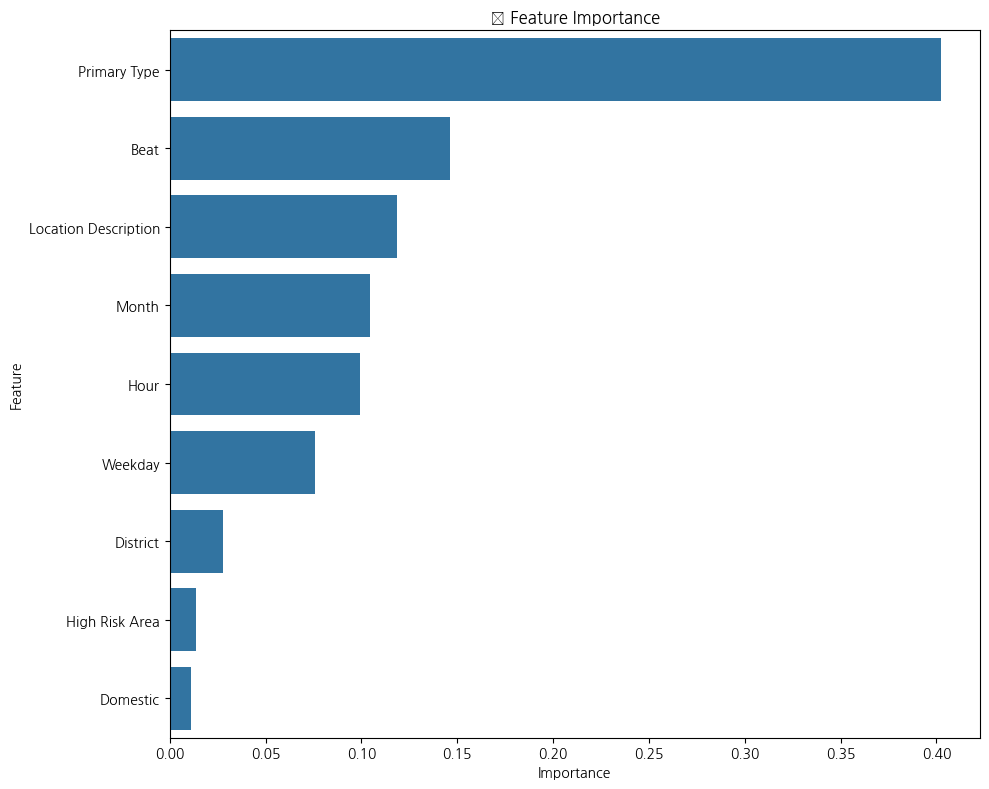

In [ ]:
# feature 중요도 추출
importances = rf_model.feature_importances_  # rf_model: 학습한 랜덤포레스트 모델
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('🔍 Feature Importance')
plt.tight_layout()
plt.show()


### 중심좌표로 거리변수 추가

In [ ]:
# 데이터의 평균으로 추출
area_coords = chicago.groupby('Community Area Name')[['Latitude', 'Longitude']].mean().reset_index()

In [ ]:
# # great_circle은 지구의 곡률을 고려한 두 지점 간의 거리를 km 또는 mile 단위로 계산
# from geopy.distance import great_circle

In [ ]:
# # 2. 고위험 지역들의 위경도 좌표 리스트 추출
# high_risk_points = area_coords[area_coords['Community Area Name'].isin(high_risk_list)][['Latitude', 'Longitude']].values.tolist()

# # 3. 각 사건에서 가장 가까운 고위험 지역까지 거리 계산 함수
# def min_distance_to_high_risk(row):
#     crime_loc = (row['Latitude'], row['Longitude']) # 발생 위도경도 튜플로 저장
#     distances = [great_circle(crime_loc, risk_point).kilometers for risk_point in high_risk_points] # 고위험좌표간의 거리 모두 계산
#     return min(distances) # 가장 가까운 거리만

In [ ]:
# chicago['Dist_to_Nearest_HighRisk'] = chicago.apply(min_distance_to_high_risk, axis=1)

In [ ]:
import numpy as np
# 2. 고위험 지역들의 위경도 좌표 리스트 추출
high_risk_points = area_coords[area_coords['Community Area Name'].isin(high_risk_list)][['Latitude', 'Longitude']].values.tolist()

In [ ]:
from geopy.distance import great_circle
from tqdm import tqdm

# tqdm 설정
tqdm.pandas()

# 고위험 지역 좌표 리스트 만들기
high_risk_points = area_coords[
    area_coords['Community Area Name'].isin(high_risk_list)
][['Latitude', 'Longitude']].values

In [ ]:
def fast_min_distance(lat, lon, high_risk_points):
    crime_loc = (lat, lon)
    # 거리 리스트를 NumPy 배열로 변환
    distances = np.array([great_circle(crime_loc, (r_lat, r_lon)).kilometers for r_lat, r_lon in high_risk_points])
    return distances.min()

# 진행률이 보이도록 tqdm.pandas() 사용
chicago['Dist_to_Nearest_HighRisk'] = chicago.progress_apply(
    lambda row: fast_min_distance(row['Latitude'], row['Longitude'], high_risk_points),
    axis=1
)

100%|██████████| 8276672/8276672 [24:40<00:00, 5591.35it/s]


In [ ]:
chicago.to_csv('/content/drive/MyDrive/final_csv/chicago_with_distance.csv', index=False)

In [ ]:
features = [
    'Primary Type', 'Location Description', 'Domestic',
    'Hour', 'Weekday', 'Month',
    'District', 'Beat',
    'High Risk Area',
    'Dist_to_Nearest_HighRisk',
    'Latitude', 'Longitude'  # 추가
]

target = 'Arrest'

In [ ]:
# 결측치 제거
ml_2= chicago[features + [target]].dropna()

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoded = ml_2.copy()
label_cols = ['Primary Type', 'Location Description', 'District', 'Beat']

encoders = {}
for col in label_cols:
    le = LabelEncoder()
    encoded[col] = le.fit_transform(encoded[col])
    encoders[col] = le  # 나중에 역변환용으로 저장


In [ ]:
from sklearn.model_selection import train_test_split

X_data = encoded.drop(columns=[target])
y_data = encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.3, random_state=42)


### 거리변수 추가 후 로지스틱 회귀

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 모델 생성
log_model = LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced')

# 학습
log_model.fit(X_train, y_train)

# 예측
y_pred = log_model.predict(X_test)

In [ ]:
# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# 평가 결과 출력
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5715

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.80      0.57      0.66   1848379
        True       0.32      0.58      0.41    630467

    accuracy                           0.57   2478846
   macro avg       0.56      0.58      0.54   2478846
weighted avg       0.68      0.57      0.60   2478846


혼동 행렬 (Confusion Matrix):
 [[1049087  799292]
 [ 262878  367589]]


-> 균형은 좋아짐 하지만 성능 불안정

### 거리변수 추가 후 Random Forest Classfier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

# 학습
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
# 예측
y_pred_rf = rf_model.predict(X_test)

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_rf))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred_rf))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred_rf))

정확도 (Accuracy): 0.8802083711533512

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.88      0.97      0.92   1848379
        True       0.88      0.61      0.72    630467

    accuracy                           0.88   2478846
   macro avg       0.88      0.79      0.82   2478846
weighted avg       0.88      0.88      0.87   2478846


혼동 행렬 (Confusion Matrix):
 [[1796165   52214]
 [ 244731  385736]]


- 체포(True) 클래스에 대해:

    정밀도 0.88 → 체포된다고 예측한 것 중 88%는 실제로도 체포됨.

    재현율 0.61 → 실제 체포된 사건 중 61%만 잡아냄.(개선 해야함!)

    F1-score 0.72 → 정밀도와 재현율 균형이 괜찮은 편.

      랜덤 포레스트 모델이 불균형한 상황에서도 훨씬 나은 성능을 보여줌.

      특히 비체포 클래스는 거의 완벽하게 예측, 체포 클래스도 어느 정도 잘 잡아내고 있음.

      정밀도(precision)는 높은데 재현율(recall)이 낮다는 건, 모델이 보수적으로 체포를 예측하고 있다는 뜻.

- Feature Importance

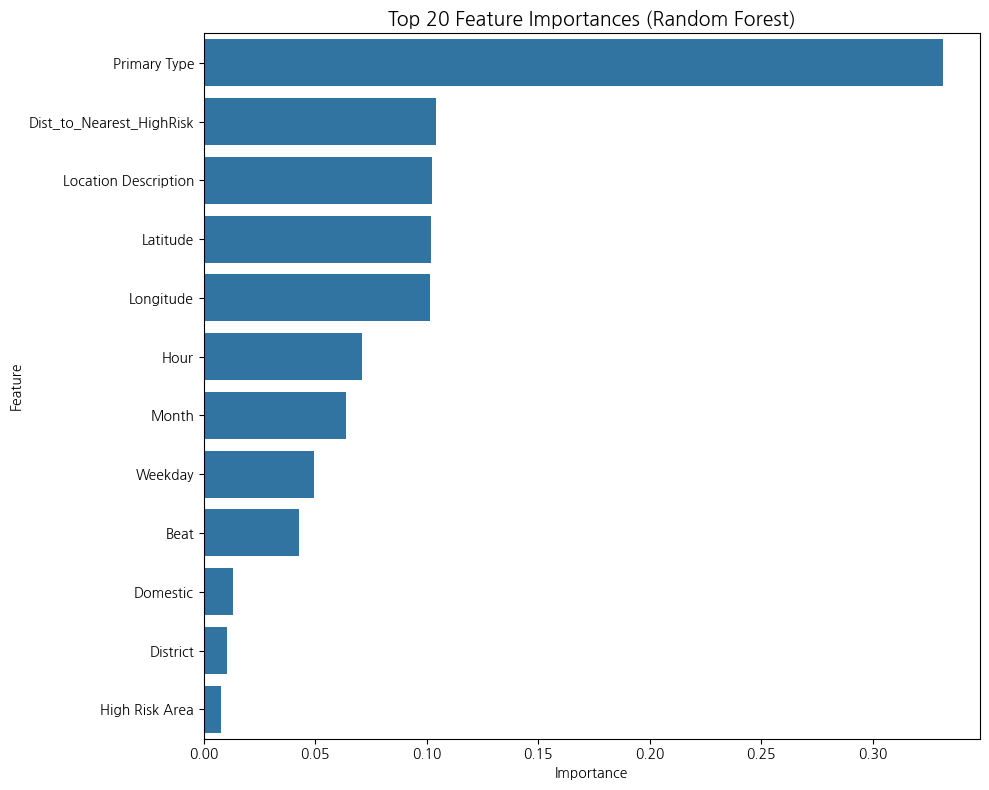

In [ ]:
# 특성 중요도 추출
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 데이터프레임으로 정리
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=14)
plt.tight_layout()
plt.show()

- 거리피처 만든 것 제외하고 비교 (* 경도, 위도 포함)

In [ ]:
features_no_dist = [
    'Primary Type', 'Location Description', 'Domestic',
    'Hour', 'Weekday', 'Month',
    'District', 'Beat',
    'Latitude', 'Longitude'
]

In [ ]:
# 데이터셋 구성
ml_data_no_dist = chicago[features_no_dist + [target]].dropna()

# 라벨 인코딩 (카테고리형)
from sklearn.preprocessing import LabelEncoder
le_dict = {}
for col in features_no_dist:
    if ml_data_no_dist[col].dtype == 'object':
        le = LabelEncoder()
        ml_data_no_dist[col] = le.fit_transform(ml_data_no_dist[col])
        le_dict[col] = le  # 나중에 역변환용으로 저장

In [ ]:
# X, y 설정
X_data = ml_data_no_dist[features_no_dist]
y_data = ml_data_no_dist['Arrest']

In [ ]:
# 훈련 / 테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.3, random_state=42)

# 모델 학습
from sklearn.ensemble import RandomForestClassifier
rf_model_no_dist = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model_no_dist.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
# 예측
y_pred = rf_model_no_dist.predict(X_test)

# 평가
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 보고서:\n", classification_report(y_test, y_pred))
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))

정확도: 0.8801240577268616

분류 보고서:
               precision    recall  f1-score   support

       False       0.88      0.97      0.92   1848379
        True       0.88      0.62      0.72    630467

    accuracy                           0.88   2478846
   macro avg       0.88      0.79      0.82   2478846
weighted avg       0.88      0.88      0.87   2478846


혼동 행렬:
 [[1793675   54704]
 [ 242450  388017]]


-> 거리 변수 포함 전후 별 차이 없음

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 사용할 피처와 타겟 정의
features_with_dist = [
    'Primary Type', 'Location Description', 'Domestic',
    'Hour', 'Weekday', 'Month',
    'District', 'Beat',
    'Dist_to_Nearest_HighRisk'
]
target = 'Arrest'

# 필요한 열만 추출하고 결측치 제거
ml_data_dist = chicago[features_with_dist + [target]].dropna()

# 라벨 인코딩 적용
le_dict = {}  # 나중에 역변환용
for col in features_with_dist:
    if ml_data_dist[col].dtype == 'object':
        le = LabelEncoder()
        ml_data_dist[col] = le.fit_transform(ml_data_dist[col])
        le_dict[col] = le

# 타겟 변수도 라벨 인코딩 (True/False → 1/0)
ml_data_dist[target] = ml_data_dist[target].astype(int)

In [ ]:
X_data = ml_data_dist.drop(columns=['Arrest'])
y_data = ml_data_dist['Arrest']  # 타겟 변수

from sklearn.model_selection import train_test_split
# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data,
    test_size=0.3,
    stratify=y_data,      # 클래스 비율 유지
    random_state=42       # 결과 재현 가능하게
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 모델 정의
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced',n_jobs=-1)

# 모델 학습
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
# 예측
# y_pred = rf_model.predict(X_test)

# 평가
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))


정확도 (Accuracy): 0.8784708691060276

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

           0       0.88      0.97      0.92   1848379
           1       0.87      0.62      0.72    630467

    accuracy                           0.88   2478846
   macro avg       0.87      0.79      0.82   2478846
weighted avg       0.88      0.88      0.87   2478846


혼동 행렬 (Confusion Matrix):
 [[1789360   59019]
 [ 242233  388234]]


| 모델 버전 | 거리 피처 | 위경도 | Accuracy | Recall(체포) | 특징                    |
|-----------|------------|--------|----------|---------------|-------------------------|
| ①         | ✅ 포함     | ✅ 포함 | 0.8802   | 0.61          | 가장 높은 정확도        |
| ②         | ❌ 제외     | ✅ 포함 | 0.8801   | 0.62          | 유사 성능, Recall ↑     |
| ③ (지금)  | ✅ 포함     | ❌ 제외 | 0.8785   | 0.62          | 정확도 ↓, Recall 동일   |


- SMOTE 오버샘플링

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# 1. 피처 정의
features_with_all = [
    'Primary Type', 'Location Description', 'Domestic',
    'Hour', 'Weekday', 'Month',
    'District', 'Beat',
    'Latitude', 'Longitude',
    'Dist_to_Nearest_HighRisk'
]

# 2. 필요한 데이터만 추출하고 결측 제거
ml_data_all = chicago[features_with_all + ['Arrest']].dropna()

In [ ]:
# 3. 라벨 인코딩
le_dict_all = {}
for col in features_with_all:
    if ml_data_all[col].dtype == 'object':
        le = LabelEncoder()
        ml_data_all[col] = le.fit_transform(ml_data_all[col])
        le_dict_all[col] = le

# 4. 타겟 인코딩
target_le = LabelEncoder()
ml_data_all['Arrest'] = target_le.fit_transform(ml_data_all['Arrest'])

In [ ]:
# 5. 훈련/테스트 분할
X = ml_data_all[features_with_all]
y = ml_data_all['Arrest']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# 6. SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

<ipython-input-20-4f96fce07fca>:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


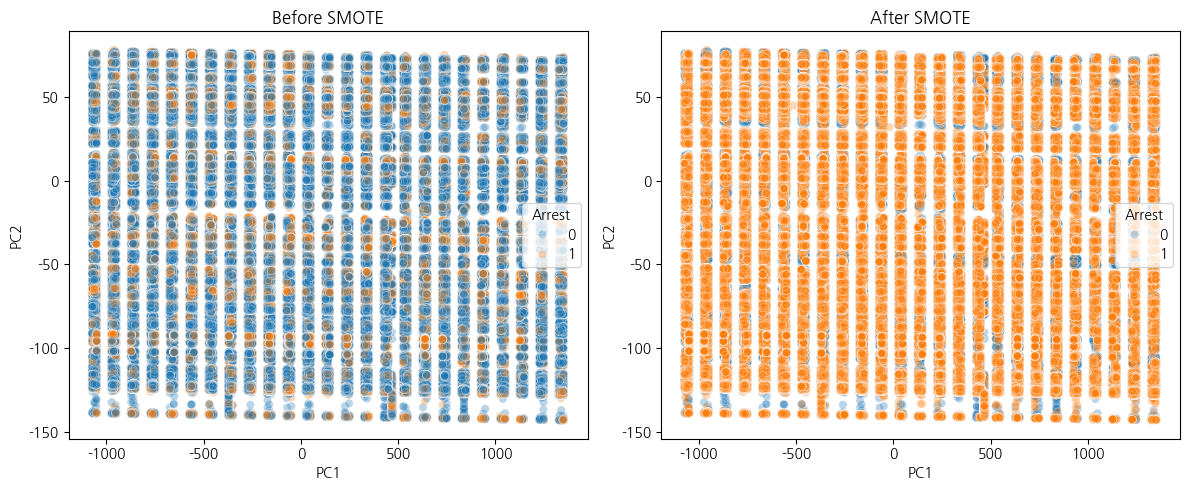

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA로 2차원으로 축소
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_resampled_pca = pca.transform(X_resampled)

# 시각화용 DataFrame
import pandas as pd

pca_df_before = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
pca_df_before['Arrest'] = y_train.values

pca_df_after = pd.DataFrame(X_resampled_pca, columns=['PC1', 'PC2'])
pca_df_after['Arrest'] = y_resampled.values

# 시각화 (SMOTE 전)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df_before, x='PC1', y='PC2', hue='Arrest', alpha=0.3)
plt.title("Before SMOTE")

# 시각화 (SMOTE 후)
plt.subplot(1, 2, 2)
sns.scatterplot(data=pca_df_after, x='PC1', y='PC2', hue='Arrest', alpha=0.3)
plt.title("After SMOTE")

plt.tight_layout()
plt.show()

In [ ]:
print("Before SMOTE:", X_train.shape)
print("After SMOTE:", X_resampled.shape)

Before SMOTE: (5783973, 11)
After SMOTE: (8625768, 11)


In [ ]:
# 7. 랜덤 포레스트 모델 학습
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model_smote.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
# 8. 예측 및 평가
y_pred_smote = rf_model_smote.predict(X_test)

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_smote))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred_smote))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred_smote))

정확도 (Accuracy): 0.8569999911249024

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

           0       0.89      0.92      0.91   1848379
           1       0.74      0.68      0.71    630467

    accuracy                           0.86   2478846
   macro avg       0.82      0.80      0.81   2478846
weighted avg       0.85      0.86      0.85   2478846


혼동 행렬 (Confusion Matrix):
 [[1697561  150818]
 [ 203657  426810]]


#### 체포 예측 모델 성능 비교 (Random Forest 기준)

| 모델 버전       | SMOTE 적용 | 거리 변수 | 위/경도 | Accuracy | Recall (체포=1) | 특징 요약 |
|----------------|-------------|------------|-----------|----------|------------------|------------|
| ✅ 버전 A      | ❌ 미적용   | ✅ 포함    | ✅ 포함   | 0.8802   | 0.61             | 가장 높은 정확도, Recall 낮음 |
| ✅ 버전 B      | ❌ 미적용   | ❌ 제외    | ✅ 포함   | 0.8801   | 0.62             | 유사 정확도, Recall 약간 ↑ |
| ✅ 버전 C      | ❌ 미적용   | ✅ 포함    | ❌ 제외   | 0.8785   | 0.62             | 정확도 ↓, Recall 동일 |
| ✅ 버전 D (최신) | ✅ **적용** | ✅ 포함    | ❌ 제외   | 0.8570   | **0.68** 🔼      | Recall **대폭 개선**, **정확도 일부 감소** |



### LIGT GBM(거리변수 위경도 모두 포함)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 모델 생성
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 학습
lgbm_model.fit(X_resampled, y_resampled) # SMOTE 한 후 사용

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4312884, number of negative: 4312884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 8625768, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(n_jobs=-1, random_state=42)

In [ ]:
# 예측
y_pred_lgbm = lgbm_model.predict(X_test)

# 평가
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

Accuracy: 0.8356658703283706

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89   1848379
           1       0.67      0.71      0.69    630467

    accuracy                           0.84   2478846
   macro avg       0.78      0.80      0.79   2478846
weighted avg       0.84      0.84      0.84   2478846


Confusion Matrix:
 [[1622236  226143]
 [ 181216  449251]]


| 모델 버전              | Accuracy | Recall (체포) | 특징                                              |
|------------------------|----------|----------------|---------------------------------------------------|
| Random Forest + SMOTE  | 0.8570   | 0.68           | f1-score와 균형은 있었지만 성능은 조금 떨어짐     |
| LightGBM + SMOTE       | 0.8357   | 0.71           | **Recall 향상**됨, **정확도는 약간 낮음**              |


- 피처 조합 다르게(전체적)

In [22]:
features = [
    'Primary Type', 'Description', 'Location Description',
    'Community Area', 'Domestic', 'Hour', 'Weekday', 'Month',
    'Latitude', 'Longitude', 'Dist_to_Nearest_HighRisk'
]

target = 'Arrest'

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 필요한 열 추출
ml_df = chicago[features + [target]].dropna().copy()

# 라벨 인코딩
le_dict = {}
for col in features:
    if ml_df[col].dtype == 'object':
        le = LabelEncoder()
        ml_df[col] = le.fit_transform(ml_df[col])
        le_dict[col] = le  # 역변환용

# 타겟도 인코딩
target_le = LabelEncoder()
ml_df[target] = target_le.fit_transform(ml_df[target])

In [24]:
# Feature / Target 분리
X_data = ml_df[features]
y_data = ml_df[target]

# 훈련 / 테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 모델 학습
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
# 예측
y_pred = rf_model.predict(X_test)

# 평가
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

정확도 (Accuracy): 0.8902489303490414

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93   1848379
           1       0.90      0.64      0.75    630467

    accuracy                           0.89   2478846
   macro avg       0.89      0.81      0.84   2478846
weighted avg       0.89      0.89      0.88   2478846


혼동 행렬 (Confusion Matrix):
 [[1801230   47149]
 [ 224907  405560]]


#### 지금까지 비교

| 모델                   | Accuracy | Recall (체포) | 특징                          |
|------------------------|----------|----------------|-------------------------------|
| Random Forest (지금)   | 0.8902   | 0.64           | 가장 좋은 성능        |
| LightGBM + SMOTE       | 0.8357   | 0.71           | Recall ↑, Accuracy ↓          |
| RF + SMOTE             | 0.8570   | 0.68           | 균형 있음, 성능 중간           |
| RF (거리만 포함)       | 0.8785   | 0.62           | 정확도 ↓                      |
| RF (위경도만)          | 0.8801   | 0.62           | 균형 좋음                      |

<ipython-input-12-878fe176958b>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='coolwarm')


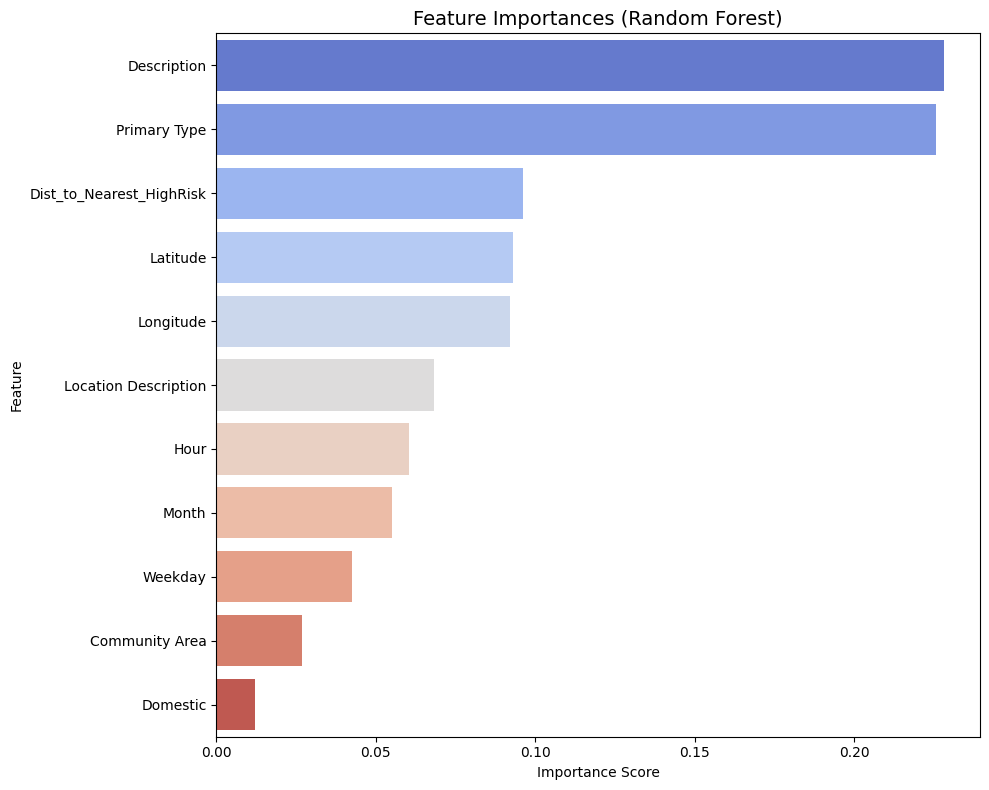

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature Importance 추출
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 데이터프레임으로 정리
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Feature 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='coolwarm')
plt.title('Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

* smote 적용

In [25]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# SMOTE 적용 (클래스 균형 맞추기)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 클래스 분포 확인
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({0: 4312884, 1: 1471089})
After SMOTE: Counter({1: 4312884, 0: 4312884})


### 그리드 서치

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 기본 모델
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# 하이퍼파라미터 탐색 공간
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }
param_grid = {
    'n_estimators': [100],          # 기본값
    'max_depth': [10, None],        # 깊이 제한 / 무제한 비교
    'min_samples_split': [2],       # 기본값
    'min_samples_leaf': [1, 2]      # 리프 노드 수만 조금 튜닝
}

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# 평가 지표 구성
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,       # 여러 지표
    refit='f1',            # f1 기준으로 최종 모델 선택 (변경 가능)
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [ ]:
# 학습
grid_search.fit(X_resampled, y_resampled)

# 결과 보기
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)  # refit 기준(f1)
print("Best Accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


데이터가 커서 그리드 서치가 잘 진행되지 않음